In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurusd60/EURUSD60.csv


# Hipótesis 0: Es mejor pasar a un problema de clasificación con el label 1 antes de que realmente ocurra para predecir el evento real
Si, por ejemplo, la vela 2 tiene el evento (es muy bajista y además es un marubozu), es mejor tratar de predecir la vela 1. Es decir, correr el label 1 uno a la izquierda.
Compararé esta hipótesis con la contraria (evento = label 1 directamente) gracias a un sencillo backtest de mercado. Esta nueva hipótesis la haré en otro documento.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Dataset INICIAL
Con esta función cogemos un dataset del mercado con solo los datos principales como son: Date, Time, Open, High, Low, Close y Volume:



In [26]:
data = pd.read_csv("/kaggle/input/eurusd60/EURUSD60.csv", header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
data

,date,time,open,high,low,close,volume
0,2012.12.21,12:00,1.32163,1.32243,1.31911,1.32016,3568
1,2012.12.21,13:00,1.32012,1.32301,1.31994,1.32091,3611
2,2012.12.21,14:00,1.32090,1.32135,1.31976,1.32004,3034
3,2012.12.21,15:00,1.32000,1.32171,1.31918,1.32005,3257
4,2012.12.21,16:00,1.32006,1.32136,1.31947,1.32021,3444
...,...,...,...,...,...,...,...
64995,2023.07.07,20:00,1.09632,1.09728,1.09631,1.09718,3173
64996,2023.07.07,21:00,1.09717,1.09734,1.09665,1.09677,2198
64997,2023.07.07,22:00,1.09677,1.09704,1.09658,1.09674,1705
64998,2023.07.07,23:00,1.09674,1.09696,1.09633,1.09668,1733


# Dataset Transformado

Para trasformarlo en un dataset con más indicadores como: SMA200, SMA500, EMA (10, 22, 40, 100), Bandas de bollinger, RSI, MACD, ROC, WILLIAMS R, DX y ADX, ADXR, AROON UP Y DOWN, OBV, ATR, NATR. 

Estos indicadores proporcionan más información predictiva al algoritmo de Machine Learning.

In [27]:
# Cargar el archivo CSV en un DataFrame
file_path = '/kaggle/input/eurusd60/EURUSD60.csv'

def preprocess_indicators(file_path):
    data = pd.read_csv(file_path, header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])

    # Media móviles simples
    data['SMA_200'] = data['close'].rolling(window=200).mean()
    data['SMA_500'] = data['close'].rolling(window=500).mean()

    # Medias móviles exponenciales
    data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()
    data['EMA_22'] = data['close'].ewm(span=22, adjust=False).mean()
    data['EMA_40'] = data['close'].ewm(span=40, adjust=False).mean()
    data['EMA_100'] = data['close'].ewm(span=100, adjust=False).mean()

    # Bandas de Bollinger
    data['SMA_14'] = data['close'].rolling(window=14).mean()
    data['STD_14'] = data['close'].rolling(window=14).std()
    data['Bollinger_Upper'] = data['SMA_14'] + (data['STD_14'] * 2)
    data['Bollinger_Lower'] = data['SMA_14'] - (data['STD_14'] * 2)

    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = data['close'].ewm(span=12, adjust=False).mean()
    exp2 = data['close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=9, adjust=False).mean()
    data['MACD'] = macd
    data['Signal_Line'] = signal_line

    # ROC
    data['ROC'] = data['close'].pct_change(periods=10) * 100

    # WILLR
    n = 14
    data['WILLR'] = -100 * ((data['high'].rolling(n).max() - data['close']) / (
                data['high'].rolling(n).max() - data['low'].rolling(n).min()))

    # DX y ADX
    plus_dm = data['high'].diff().where(data['high'].diff() > data['low'].diff(), 0)
    minus_dm = -data['low'].diff().where(data['low'].diff() > data['high'].diff(), 0)
    tr = data['high'].combine(data['close'].shift(), max) - data['low'].combine(data['close'].shift(), min)
    atr = tr.rolling(window=14).mean()
    plus_di = 100 * plus_dm.rolling(window=14).mean() / atr
    minus_di = 100 * minus_dm.rolling(window=14).mean() / atr
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    data['ADX'] = dx.rolling(window=14).mean()
    data['DX'] = dx

    # ADXR
    data['ADXR'] = data['ADX'].rolling(window=14).mean()

    # APO
    data['APO'] = data['close'].ewm(span=12, adjust=False).mean() - data['close'].ewm(span=26, adjust=False).mean()

    # AROON Up y AROON Down
    n = 14
    data['AROON_Up'] = data['high'].rolling(window=n).apply(lambda x: float(np.argmax(x) + 1) / n * 100, raw=True)
    data['AROON_Down'] = data['low'].rolling(window=n).apply(lambda x: float(np.argmin(x) + 1) / n * 100, raw=True)

    # OBV
    data['OBV'] = (np.sign(data['close'].diff()) * data['volume']).fillna(0).cumsum()

    # ATR
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()

    # NATR
    data['NATR'] = (data['ATR'] / data['close']) * 100

    data.fillna(method='ffill', inplace=True)
    data.dropna(how='any', inplace=True)
    data.to_csv('5.datos_para_backtest.csv', index=False)
    return data

df = preprocess_indicators(file_path=file_path)
df

,date,time,open,high,low,close,volume,SMA_200,SMA_500,EMA_10,...,WILLR,ADX,DX,ADXR,APO,AROON_Up,AROON_Down,OBV,ATR,NATR
499,2013.01.24,02:00,1.33095,1.33123,1.33029,1.33062,961,1.333050,1.322701,1.331332,...,-53.125000,-411.980450,-106.142506,-239.191455,-0.000175,21.428571,42.857143,50283.0,0.002059,0.154708
500,2013.01.24,03:00,1.33061,1.33089,1.32978,1.33050,1153,1.333031,1.322721,1.331180,...,-54.464286,-470.677482,-96.303901,-277.972926,-0.000232,14.285714,35.714286,49130.0,0.001990,0.149568
501,2013.01.24,04:00,1.33053,1.33156,1.32968,1.33073,1217,1.333008,1.322741,1.331099,...,-51.897321,-121.429362,-130.526316,-266.403116,-0.000256,7.142857,28.571429,50347.0,0.002033,0.152763
502,2013.01.24,05:00,1.33069,1.33240,1.33068,1.33171,1539,1.332988,1.322764,1.331210,...,-36.341757,-167.565860,-75.244300,-261.296698,-0.000193,7.142857,21.428571,51886.0,0.002027,0.152221
503,2013.01.24,06:00,1.33170,1.33205,1.33116,1.33156,1425,1.332972,1.322787,1.331273,...,-35.508156,-219.221615,-96.314908,-263.476867,-0.000154,14.285714,14.285714,50461.0,0.001929,0.144889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,2023.07.07,20:00,1.09632,1.09728,1.09631,1.09718,3173,1.082125,1.077351,1.092547,...,-0.946074,80.440151,-1273.228346,-129.704733,0.001860,100.000000,42.857143,-226811.0,0.002032,0.185215
64996,2023.07.07,21:00,1.09717,1.09734,1.09665,1.09677,2198,1.082262,1.077391,1.093315,...,-5.362183,25.599433,-848.691099,-76.091013,0.002099,100.000000,35.714286,-229009.0,0.002041,0.186066
64997,2023.07.07,22:00,1.09677,1.09704,1.09658,1.09674,1705,1.082397,1.077429,1.093938,...,-5.644403,-16.509813,-717.272727,-63.710897,0.002260,92.857143,28.571429,-230714.0,0.002006,0.182945
64998,2023.07.07,23:00,1.09674,1.09696,1.09633,1.09668,1733,1.082542,1.077467,1.094436,...,-6.208843,-50.675146,-649.166667,-54.719138,0.002356,85.714286,21.428571,-232447.0,0.001979,0.180480


## Labelizar
Ahora, con este dataset con más información predictiva lo "labelizamos", es decir, que le ponemos de forma automática o computerizada un label = 1 si cumple que es una vela MARUBOZU (un tipo de vela japonesa de gran tamaño) y es bajista o alcista:

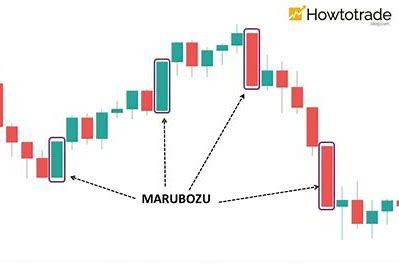

Será label = 0 si solo es una vela normal.

También calculamos las medias alcistas y bajistas. El marubozu y el hecho de ser MUY bajista/alcista (una vela más grande que las medias correspondientes) implica ser label = 1. 

Sin embargo, no será esa vela la que tenga el label = 1, será la vela anterior para que el algoritmo pueda verificar los datos matemáticos que guardan en común los puntos anteriores para que se dé de manera predictiva ese suceso.

In [28]:
def es_marubozu_bajista(row):
    # Marubozu bajista: cuerpo largo con sombras pequeñas en ambos extremos
    if (row['open'] > row['close']) and (abs(row['open'] - row['close']) > 0.7 * (row['high'] - row['low'])) and \
       (row['close'] - row['low'] <= 0.1 * (row['high'] - row['low'])) and \
       (row['high'] - row['open'] <= 0.1 * (row['high'] - row['low'])):
        return True
    return False

# Calcular la media de velas alcistas y bajistas
velas_alcistas = df[df['close'] > df['open']]
media_alcistas = velas_alcistas['close'].mean()

velas_bajistas = df[df['close'] < df['open']]
media_bajistas = velas_bajistas['close'].mean()

# Crear una nueva columna para las etiquetas (labels)
df['label'] = 0

for i in range(1, len(df)):
    if i in df.index:  # Asegurarse de que el índice exista
        if es_marubozu_bajista(df.iloc[i]) and (df['close'].iloc[i] < media_bajistas):
            df.at[i - 1, 'label'] = 1
        elif abs(df['open'].iloc[i] - df['close'].iloc[i]) > media_bajistas:
            df.at[i - 1, 'label'] = 1

# Contar cuántos label=1 hay
count_label_1 = df[df['label'] == 1].shape[0]
print("Número de velas con label=1:", count_label_1)

# Contadores para velas Marubozu y velas mayores que la media
count_marubozu = 0
count_mayor_que_media = 0

for index, row in df.iterrows():
    if es_marubozu_bajista(row):
        count_marubozu += 1
    if (row['close'] > media_alcistas) or (row['open'] - row['close'] > media_bajistas):
        count_mayor_que_media += 1

print("Número de velas Marubozu:", count_marubozu)
print("Número de velas mayores que la media:", count_mayor_que_media)

df.to_csv("marubozu_data_label_EURUSD60.csv")
df.tail(25)

Número de velas con label=1: 1029
Número de velas Marubozu: 1693
Número de velas mayores que la media: 25973


,date,time,open,high,low,close,volume,SMA_200,SMA_500,EMA_10,...,ADX,DX,ADXR,APO,AROON_Up,AROON_Down,OBV,ATR,NATR,label
64975,2023.07.07,00:00,1.08881,1.08929,1.08852,1.08883,632,1.080256,1.076962,1.087927,...,-469.685663,-162.028986,-122.198369,0.000474,42.857143,57.142857,-269011.0,0.001974,0.181256,0
64976,2023.07.07,01:00,1.08853,1.08887,1.08848,1.08879,214,1.080359,1.076971,1.088084,...,-489.221775,-140.641711,-173.593616,0.000519,35.714286,50.000000,-269225.0,0.001836,0.168601,0
64977,2023.07.07,02:00,1.08879,1.08911,1.08876,1.08910,505,1.080449,1.076980,1.088269,...,-504.307984,-136.018957,-225.432094,0.000574,28.571429,42.857143,-268720.0,0.001716,0.157535,0
64978,2023.07.07,03:00,1.08910,1.08949,1.08893,1.08895,533,1.080534,1.076990,1.088393,...,-533.082863,-157.663126,-279.117445,0.000597,21.428571,35.714286,-269253.0,0.001695,0.155655,0
64979,2023.07.07,04:00,1.08895,1.08912,1.08824,1.08853,1459,1.080621,1.077000,1.088418,...,-550.448614,-86.798680,-332.780576,0.000576,14.285714,28.571429,-270712.0,0.001553,0.142656,0
64980,2023.07.07,05:00,1.08851,1.08913,1.08849,1.08870,1203,1.080708,1.077011,1.088469,...,-603.282029,-83.146067,-394.293777,0.000566,7.142857,21.428571,-269509.0,0.001496,0.137385,0
64981,2023.07.07,06:00,1.08870,1.08885,1.08834,1.08860,638,1.080794,1.077023,1.088493,...,-640.455602,-75.724138,-446.584573,0.000544,78.571429,14.285714,-270147.0,0.001231,0.113055,0
64982,2023.07.07,07:00,1.08858,1.08915,1.08858,1.08877,730,1.080881,1.077038,1.088543,...,-724.992635,-80.921053,-509.556610,0.000534,71.428571,7.142857,-269417.0,0.001124,0.103262,0
64983,2023.07.07,08:00,1.08877,1.08951,1.08857,1.08912,840,1.080971,1.077053,1.088648,...,-189.831440,-127.743271,-494.662032,0.000548,100.000000,7.142857,-268577.0,0.000840,0.077126,0
64984,2023.07.07,09:00,1.08916,1.08963,1.08862,1.08875,1108,1.081059,1.077066,1.088667,...,-176.559777,-170.852018,-476.381049,0.000523,100.000000,7.142857,-269685.0,0.000770,0.070723,0


# Dividir los datos

## Correlación con la etiqueta
Antes de dividir los datos para su entrenamiento quiero ver la correlación con la etiqueta, viendo con un algoritmo de random forest la importancia de cada indicador respecto a la etiqueta, para utilizar solo aquellos que realmente tengan mayor valor predictivo.

In [29]:

# Cargar los datos
file_path = "/kaggle/working/marubozu_data_label_EURUSD60.csv"
data = pd.read_csv(file_path)

# Seleccionar las columnas de características y la columna objetivo (etiqueta)
features = data.drop(columns=["date", "time", "label"])
labels = data["label"]

# Reemplazar los valores infinitos con NaN
features = features.replace([np.inf, -np.inf], np.nan)

# Rellenar los NaN con la media de cada columna
features = features.apply(lambda x: x.fillna(x.mean()), axis=0)

# Asegurarse de que todos los datos sean de tipo flotante
features = features.astype(float)

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Entrenar un bosque aleatorio
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Obtener la importancia de las características
importance = clf.feature_importances_
feature_importance = pd.Series(importance, index=features.columns).sort_values(ascending=False)

# Imprimir la importancia de las características
print("Importancia de las Características:")
print(feature_importance)

# Análisis descriptivo
label_1 = data[data['label'] == 1]
label_0 = data[data['label'] == 0]

print("Resumen de las velas con etiqueta 1:")
print(label_1.describe())

print("Resumen de las velas con etiqueta 0:")
print(label_0.describe())

# Eliminar las columnas no numéricas antes de calcular la correlación
numerical_data = data.drop(columns=["date", "time"])

# Calcular la correlación
correlations_with_label = numerical_data.corr()['label'].sort_values(ascending=False)

# Imprimir las correlaciones
print("Correlaciones con la etiqueta:")
print(correlations_with_label)

# Calcular las correlaciones con la etiqueta
correlations_with_label = features.corrwith(labels)

# Seleccionar las columnas que tienen una correlación mayor a 0.01
selected_features = features.loc[:, np.abs(correlations_with_label) > 0.01]

# Verificar si 'Unnamed: 0' está en las columnas y eliminar si es necesario
if 'Unnamed: 0' in selected_features.columns:
    selected_features = selected_features.drop(columns=['Unnamed: 0'])

Importancia de las Características:
volume             0.045157
Unnamed: 0         0.045036
OBV                0.043670
SMA_500            0.043586
ROC                0.043536
RSI                0.042279
WILLR              0.042256
NATR               0.040567
APO                0.040148
STD_14             0.039945
MACD               0.039689
SMA_200            0.039464
ATR                0.038267
Signal_Line        0.037402
EMA_100            0.035962
Bollinger_Lower    0.035587
close              0.035211
high               0.035063
open               0.034567
SMA_14             0.034090
EMA_40             0.034058
Bollinger_Upper    0.033832
EMA_22             0.033210
low                0.033190
EMA_10             0.032777
AROON_Up           0.018332
AROON_Down         0.017630
ADXR               0.004431
ADX                0.001059
DX                 0.000000
dtype: float64
Resumen de las velas con etiqueta 1:
         Unnamed: 0         open         high          low        close 

# MODELADO

## INTENTO 1
No funciona por el desbalance de clases.

In [30]:
# Seleccionar las columnas de características y la columna objetivo (etiqueta)
features = data.drop(columns=["Unnamed: 0", "date", "time", "label"])
labels = data["label"]

# Reemplazar los valores infinitos con NaN y llenar NaN con la media de cada columna
features = features.replace([np.inf, -np.inf], np.nan)
features = features.apply(lambda x: x.fillna(x.mean()), axis=0)

# Asegurarse de que todos los datos sean de tipo flotante
features = features.astype(float)

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# Entrenar un bosque aleatorio
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Métricas de evaluación
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)

(accuracy_train, accuracy_test, classification_rep, confusion_mat)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9998449612403101,
 0.9859700798387722,
 '              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99     12720\n           1       0.00      0.00      0.00       181\n\n    accuracy                           0.99     12901\n   macro avg       0.49      0.50      0.50     12901\nweighted avg       0.97      0.99      0.98     12901\n',
 array([[12720,     0],
        [  181,     0]]))

Hay un sobreajuste por un desbalance grave de clases. solucionémoslo

## Intento 2
Ahora aplicamos la técnica SMOTE para el balanceo de clases y reintentamos, viendo que efectivamente ahora si funciona bien.

In [42]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# Aplicar SMOTE solo en los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entrenar un bosque aleatorio con los datos balanceados
clf_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
clf_resampled.fit(X_train_resampled, y_train_resampled)

# Evaluar el modelo en el conjunto de prueba (no resampleado)
y_pred_test = clf_resampled.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)
confusion_mat = confusion_matrix(y_test, y_pred_test)

# Mostrar métricas
(accuracy_test, classification_rep, confusion_mat)

(0.9781412293620649,
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99     12720\n           1       0.01      0.01      0.01       181\n\n    accuracy                           0.98     12901\n   macro avg       0.50      0.50      0.50     12901\nweighted avg       0.97      0.98      0.98     12901\n',
 array([[12618,   102],
        [  180,     1]]))

# Guardo el modelo para su reutilización

In [32]:
from joblib import dump, load

# Guardar el modelo
dump(clf_resampled, 'random_forest_model.joblib')

# Si también necesitas guardar el objeto de escalado, puedes hacerlo así:
dump(scaler, 'scaler.joblib')


['scaler.joblib']

# Prueba en entorno real

## Funciones de preprocesamiento

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_indicators(data):
    # ... [Todas las líneas de tu código de preprocesamiento aquí]
    data = pd.read_csv("/kaggle/input/eurusd60/EURUSD60.csv", header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])

    # Media móviles simples
    data['SMA_200'] = data['close'].rolling(window=200).mean()
    data['SMA_500'] = data['close'].rolling(window=500).mean()

    # Medias móviles exponenciales
    data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()
    data['EMA_22'] = data['close'].ewm(span=22, adjust=False).mean()
    data['EMA_40'] = data['close'].ewm(span=40, adjust=False).mean()
    data['EMA_100'] = data['close'].ewm(span=100, adjust=False).mean()

    # Bandas de Bollinger
    data['SMA_14'] = data['close'].rolling(window=14).mean()
    data['STD_14'] = data['close'].rolling(window=14).std()
    data['Bollinger_Upper'] = data['SMA_14'] + (data['STD_14'] * 2)
    data['Bollinger_Lower'] = data['SMA_14'] - (data['STD_14'] * 2)

    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = data['close'].ewm(span=12, adjust=False).mean()
    exp2 = data['close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=9, adjust=False).mean()
    data['MACD'] = macd
    data['Signal_Line'] = signal_line

    # ROC
    data['ROC'] = data['close'].pct_change(periods=10) * 100

    # WILLR
    n = 14
    data['WILLR'] = -100 * ((data['high'].rolling(n).max() - data['close']) / (
                data['high'].rolling(n).max() - data['low'].rolling(n).min()))

    # DX y ADX
    plus_dm = data['high'].diff().where(data['high'].diff() > data['low'].diff(), 0)
    minus_dm = -data['low'].diff().where(data['low'].diff() > data['high'].diff(), 0)
    tr = data['high'].combine(data['close'].shift(), max) - data['low'].combine(data['close'].shift(), min)
    atr = tr.rolling(window=14).mean()
    plus_di = 100 * plus_dm.rolling(window=14).mean() / atr
    minus_di = 100 * minus_dm.rolling(window=14).mean() / atr
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    data['ADX'] = dx.rolling(window=14).mean()
    data['DX'] = dx

    # ADXR
    data['ADXR'] = data['ADX'].rolling(window=14).mean()

    # APO
    data['APO'] = data['close'].ewm(span=12, adjust=False).mean() - data['close'].ewm(span=26, adjust=False).mean()

    # AROON Up y AROON Down
    n = 14
    data['AROON_Up'] = data['high'].rolling(window=n).apply(lambda x: float(np.argmax(x) + 1) / n * 100, raw=True)
    data['AROON_Down'] = data['low'].rolling(window=n).apply(lambda x: float(np.argmin(x) + 1) / n * 100, raw=True)

    # OBV
    data['OBV'] = (np.sign(data['close'].diff()) * data['volume']).fillna(0).cumsum()

    # ATR
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()

    # NATR
    data['NATR'] = (data['ATR'] / data['close']) * 100

    data.fillna(method='ffill', inplace=True)
    data.dropna(how='any', inplace=True)
    return data

def es_marubozu_bajista(row):
    # Marubozu bajista: cuerpo largo con sombras pequeñas en ambos extremos
    if (row['open'] > row['close']) and (abs(row['open'] - row['close']) > 0.7 * (row['high'] - row['low'])) and \
       (row['close'] - row['low'] <= 0.1 * (row['high'] - row['low'])) and \
       (row['high'] - row['open'] <= 0.1 * (row['high'] - row['low'])):
        return True
    return False

def label_data(df):
    # Calcular la media de velas alcistas y bajistas
    velas_alcistas = df[df['close'] > df['open']]
    media_alcistas = velas_alcistas['close'].mean()

    velas_bajistas = df[df['close'] < df['open']]
    media_bajistas = velas_bajistas['close'].mean()

    # Crear una nueva columna para las etiquetas (labels)
    df['label'] = 0

    for i in range(1, len(df)):
        if i in df.index:  # Asegurarse de que el índice exista
            if es_marubozu_bajista(df.iloc[i]) and (df['close'].iloc[i] < media_bajistas):
                df.at[i - 1, 'label'] = 1
            elif abs(df['open'].iloc[i] - df['close'].iloc[i]) > media_bajistas:
                df.at[i - 1, 'label'] = 1

    # Contar cuántos label=1 hay
    count_label_1 = df[df['label'] == 1].shape[0]
    print("Número de velas con label=1:", count_label_1)

    # Contadores para velas Marubozu y velas mayores que la media
    count_marubozu = 0
    count_mayor_que_media = 0

    for index, row in df.iterrows():
        if es_marubozu_bajista(row):
            count_marubozu += 1
        if (row['close'] > media_alcistas) or (row['open'] - row['close'] > media_bajistas):
            count_mayor_que_media += 1
    return df  # Devuelve los datos etiquetados para su uso posterior

def prepare_new_data(new_data, scaler, feature_columns, save_to_file=False):
    """
    Esta función procesa y normaliza los nuevos datos para ser utilizados en el modelo.
    
    - new_data: DataFrame con los nuevos datos.
    - scaler: objeto StandardScaler utilizado para entrenar el modelo.
    - feature_columns: columnas utilizadas por el modelo.
    - save_to_file: booleano que indica si guardar los datos procesados en un archivo CSV.
    
    Retorna: new_features_scaled, labeled_data
    """
    # Procesamiento de los datos
    processed_data = preprocess_indicators(new_data)
    
    # Etiquetar los datos
    labeled_data = label_data(processed_data)

    # Opcional: Guardar los datos procesados en un archivo CSV
    if save_to_file:
        labeled_data.to_csv('5.datos_para_backtest.csv', index=False)
    
   # Asegurarse de que las columnas estén en el mismo orden
    new_data = new_data[feature_columns]
    
    # Normalización de las características
    new_features_scaled = scaler.transform(new_data)
    
    return new_features_scaled, labeled_data

def preprocess_features(features):
    
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.apply(lambda x: x.fillna(x.mean()), axis=0)
    
    features = features.astype(float)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, scaler

# Introducir nuevos datos

In [34]:
import pandas as pd
from sklearn.exceptions import DataConversionWarning
import warnings
from joblib import load

# Ignorar las advertencias de conversión de datos de sklearn
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Cargar los datos
new_data = pd.read_csv('/kaggle/input/eurusd60/EURUSD60.csv', header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])

# Preprocesar los datos para añadir los indicadores técnicos
new_data_processed = preprocess_indicators(new_data)

# Cargar el escalador y el modelo previamente guardados
loaded_scaler = load('/kaggle/working/scaler.joblib')
loaded_model = load('/kaggle/working/random_forest_model.joblib')

# Definir las columnas de características que usaste para entrenar tu modelo
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'SMA_200', 'SMA_500', 'EMA_10', 'EMA_22', 
                   'EMA_40', 'EMA_100', 'SMA_14', 'STD_14', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI', 
                   'MACD', 'Signal_Line', 'ROC', 'WILLR', 'ADX', 'DX', 'ADXR', 'APO', 'AROON_Up', 'AROON_Down', 
                   'OBV', 'ATR', 'NATR']

# Asegurar que las columnas estén en el orden correcto
new_data_processed = new_data_processed[feature_columns]

# Reemplazar infinitos por NaN
new_data_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Reemplazar NaN por la media de la columna
new_data_processed.fillna(new_data_processed.mean(), inplace=True)

# Otra opción es eliminar las filas que contienen NaN
# new_data_processed = new_data_processed.dropna()

# Procesar los nuevos datos y hacer predicciones
new_data_scaled, labeled_data = prepare_new_data(new_data_processed, loaded_scaler, feature_columns, save_to_file=True)
predictions = loaded_model.predict(new_data_scaled)


Número de velas con label=1: 1029


# BACKTEST FINAL 
Hacemos un backtest financiero que no es más que comprobar qué hubiera pasado si en cada predicción vendemos y compramos en la siguiente vela. 
Recuerda que tratamos de predecir los momentos bajistas, así que si se han dado la mejor manera de ganar dinero es vender y luego recomprar. Ponerse en corto.

Habrá acertado?

### Vendiendo según predice

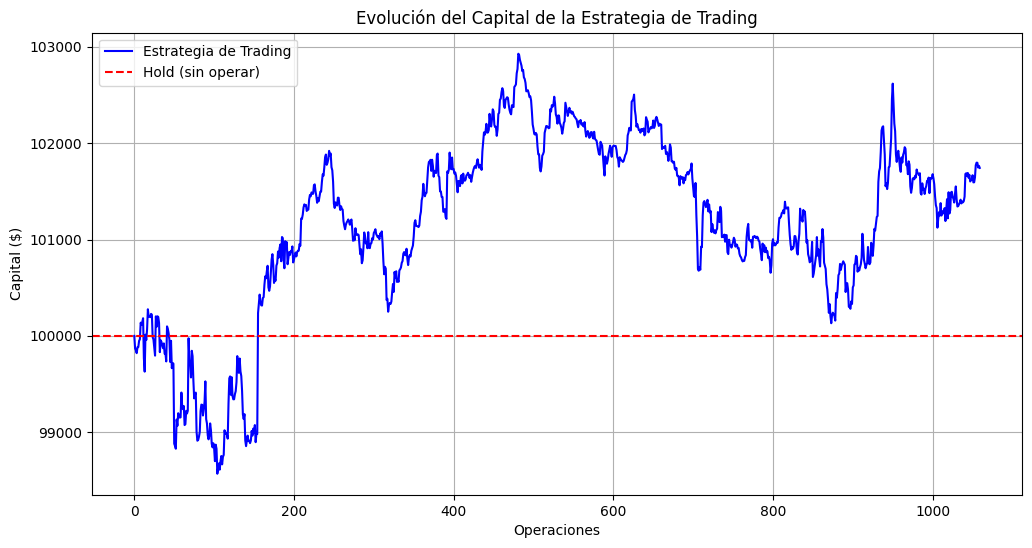

In [35]:
# Añadir las predicciones al conjunto de datos etiquetado
labeled_data['predictions'] = predictions

# Inicializar el capital y una lista para almacenar los retornos
capital = 100000  # por ejemplo
returns = []

# Iterar a través del DataFrame y simular operaciones
for i, row in labeled_data.iterrows():
    # Si el modelo predice una bajada y tienes capital para vender
    if row['predictions'] == 1 and capital >= row['close']:
        # Vender: mantener el capital, calcular retorno cuando compras en el próximo periodo
        try:
            # Calcular retorno cuando se sale de la operación en la siguiente vela
            returns.append((row['close'] - labeled_data.loc[i+1, 'close']) / labeled_data.loc[i+1, 'close'])
        except KeyError:  # Si es la última fila del DataFrame
            pass
    
# Calcular métricas de rendimiento, como la rentabilidad total y la rentabilidad promedio por operación
total_return = sum(returns)
average_return = sum(returns) / len(returns) if returns else 0

(total_return, average_return)

import matplotlib.pyplot as plt

# Calculando los retornos acumulativos
cumulative_returns = [capital]
for ret in returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret))

# Graficando
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Estrategia de Trading", color='blue')
plt.axhline(y=capital, color='r', linestyle='--', label="Hold (sin operar)")
plt.xlabel("Operaciones")
plt.ylabel("Capital ($)")
plt.title("Evolución del Capital de la Estrategia de Trading")
plt.legend()
plt.grid(True)
plt.show()

### Comprando según predice y vendiendo en la vela siguiente
Esto, que parece antintuitivo, puede darse debido a la naturaleza volátil del mercado y a que solo dejamos una vela para cerrar la operación. A veces, ne el mercado, tras un movimiento muy fuerte hay un retroceso en la siguiente vela.

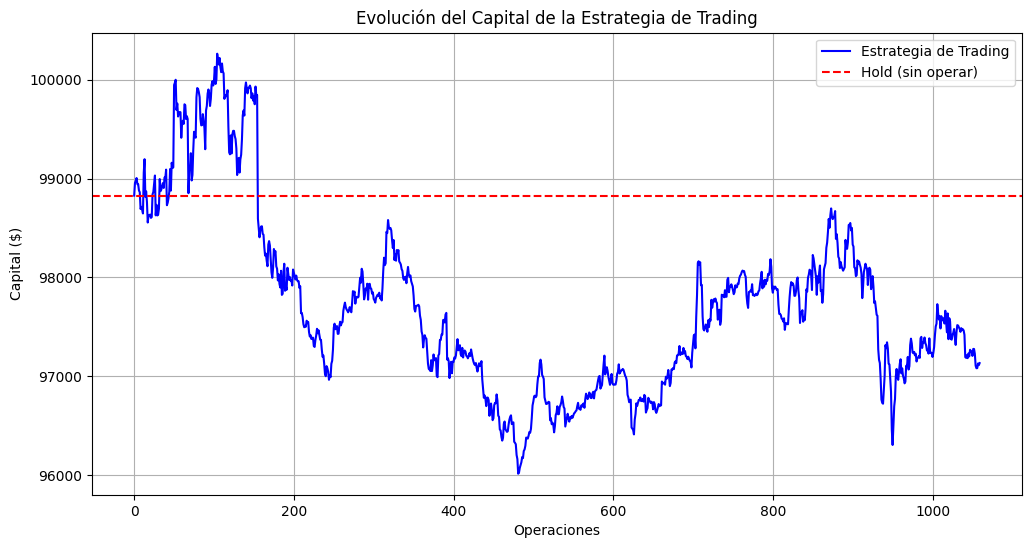

In [36]:
# Añadir las predicciones al conjunto de datos etiquetado
labeled_data['predictions'] = predictions

# Inicializar el capital y una lista para almacenar los retornos
capital = 100000  # por ejemplo
returns = []

# Iterar a través del DataFrame y simular operaciones
for i, row in labeled_data.iterrows():
    # Si el modelo predice una subida y tienes capital para comprar
    if row['predictions'] == 1 and capital >= row['close']:
        # Comprar: disminuir capital, calcular retorno cuando vendes en el próximo periodo
        capital -= row['close']
        try:
            returns.append((labeled_data.loc[i+1, 'close'] - row['close']) / row['close'])
        except KeyError:  # Si es la última fila del DataFrame
            pass
    
    # Otras condiciones de trading (p. ej., vender, mantener, etc.) pueden ser añadidas aquí...

# Calcular métricas de rendimiento, como la rentabilidad total y la rentabilidad promedio por operación
total_return = sum(returns)
average_return = sum(returns) / len(returns) if returns else 0

(total_return, average_return)

# Calculando los retornos acumulativos
cumulative_returns = [capital]
for ret in returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret))

# Graficando
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Estrategia de Trading", color='blue')
plt.axhline(y=capital, color='r', linestyle='--', label="Hold (sin operar)")
plt.xlabel("Operaciones")
plt.ylabel("Capital ($)")
plt.title("Evolución del Capital de la Estrategia de Trading")
plt.legend()
plt.grid(True)
plt.show()

# CONCLUSIÓN
No obstante, parece que comienza a acertar (BACKTEST DE VENTA) tras el período de entrenamiento, en el período de test. Así que compararemos con la hipótesis 1 (evento =  label 1, sin traslados a la izquierda) y veremos qué nos dicen los experimentos.

# Hipótesis 1
He cambiado la función def label_data para que el evento (marubozu y extra bajista) sea en la misma vela donde se produce

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocess_indicators(data):
    # ... [Todas las líneas de tu código de preprocesamiento aquí]
    data = pd.read_csv("/kaggle/input/eurusd60/EURUSD60.csv", header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])

    # Media móviles simples
    data['SMA_200'] = data['close'].rolling(window=200).mean()
    data['SMA_500'] = data['close'].rolling(window=500).mean()

    # Medias móviles exponenciales
    data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()
    data['EMA_22'] = data['close'].ewm(span=22, adjust=False).mean()
    data['EMA_40'] = data['close'].ewm(span=40, adjust=False).mean()
    data['EMA_100'] = data['close'].ewm(span=100, adjust=False).mean()

    # Bandas de Bollinger
    data['SMA_14'] = data['close'].rolling(window=14).mean()
    data['STD_14'] = data['close'].rolling(window=14).std()
    data['Bollinger_Upper'] = data['SMA_14'] + (data['STD_14'] * 2)
    data['Bollinger_Lower'] = data['SMA_14'] - (data['STD_14'] * 2)

    # RSI
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = data['close'].ewm(span=12, adjust=False).mean()
    exp2 = data['close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=9, adjust=False).mean()
    data['MACD'] = macd
    data['Signal_Line'] = signal_line

    # ROC
    data['ROC'] = data['close'].pct_change(periods=10) * 100

    # WILLR
    n = 14
    data['WILLR'] = -100 * ((data['high'].rolling(n).max() - data['close']) / (
                data['high'].rolling(n).max() - data['low'].rolling(n).min()))

    # DX y ADX
    plus_dm = data['high'].diff().where(data['high'].diff() > data['low'].diff(), 0)
    minus_dm = -data['low'].diff().where(data['low'].diff() > data['high'].diff(), 0)
    tr = data['high'].combine(data['close'].shift(), max) - data['low'].combine(data['close'].shift(), min)
    atr = tr.rolling(window=14).mean()
    plus_di = 100 * plus_dm.rolling(window=14).mean() / atr
    minus_di = 100 * minus_dm.rolling(window=14).mean() / atr
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    data['ADX'] = dx.rolling(window=14).mean()
    data['DX'] = dx

    # ADXR
    data['ADXR'] = data['ADX'].rolling(window=14).mean()

    # APO
    data['APO'] = data['close'].ewm(span=12, adjust=False).mean() - data['close'].ewm(span=26, adjust=False).mean()

    # AROON Up y AROON Down
    n = 14
    data['AROON_Up'] = data['high'].rolling(window=n).apply(lambda x: float(np.argmax(x) + 1) / n * 100, raw=True)
    data['AROON_Down'] = data['low'].rolling(window=n).apply(lambda x: float(np.argmin(x) + 1) / n * 100, raw=True)

    # OBV
    data['OBV'] = (np.sign(data['close'].diff()) * data['volume']).fillna(0).cumsum()

    # ATR
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()

    # NATR
    data['NATR'] = (data['ATR'] / data['close']) * 100

    data.fillna(method='ffill', inplace=True)
    data.dropna(how='any', inplace=True)
    return data

def es_marubozu_bajista(row):
    # Marubozu bajista: cuerpo largo con sombras pequeñas en ambos extremos
    if (row['open'] > row['close']) and (abs(row['open'] - row['close']) > 0.7 * (row['high'] - row['low'])) and \
       (row['close'] - row['low'] <= 0.1 * (row['high'] - row['low'])) and \
       (row['high'] - row['open'] <= 0.1 * (row['high'] - row['low'])):
        return True
    return False

def label_data(df):
    # Calcular la media de velas alcistas y bajistas
    velas_alcistas = df[df['close'] > df['open']]
    media_alcistas = velas_alcistas['close'].mean()

    velas_bajistas = df[df['close'] < df['open']]
    media_bajistas = velas_bajistas['close'].mean()

    # Crear una nueva columna para las etiquetas (labels)
    df['label'] = 0

    for i in range(1, len(df)):
        if i in df.index:  # Asegurarse de que el índice exista
            # Si es un Marubozu bajista y el precio de cierre es menor que la media de los bajistas
            if es_marubozu_bajista(df.iloc[i]) and (df['close'].iloc[i] < media_bajistas):
                df.at[i, 'label'] = 1
            elif abs(df['open'].iloc[i] - df['close'].iloc[i]) > media_bajistas:
                df.at[i, 'label'] = 1

    # Contar cuántos label=1 hay
    count_label_1 = df[df['label'] == 1].shape[0]
    print("Número de velas con label=1:", count_label_1)

    # Contadores para velas Marubozu y velas mayores que la media
    count_marubozu = 0
    count_mayor_que_media = 0

    for index, row in df.iterrows():
        if es_marubozu_bajista(row):
            count_marubozu += 1
        if (row['close'] > media_alcistas) or (row['open'] - row['close'] > media_bajistas):
            count_mayor_que_media += 1
    return df  # Devuelve los datos etiquetados para su uso posterior

def prepare_new_data(new_data, scaler, feature_columns, save_to_file=False):
    """
    Esta función procesa y normaliza los nuevos datos para ser utilizados en el modelo.
    
    - new_data: DataFrame con los nuevos datos.
    - scaler: objeto StandardScaler utilizado para entrenar el modelo.
    - feature_columns: columnas utilizadas por el modelo.
    - save_to_file: booleano que indica si guardar los datos procesados en un archivo CSV.
    
    Retorna: new_features_scaled, labeled_data
    """
    # Procesamiento de los datos
    processed_data = preprocess_indicators(new_data)
    
    # Etiquetar los datos
    labeled_data = label_data(processed_data)

    # Opcional: Guardar los datos procesados en un archivo CSV
    if save_to_file:
        labeled_data.to_csv('5.datos_para_backtest.csv', index=False)
    
   # Asegurarse de que las columnas estén en el mismo orden
    new_data = new_data[feature_columns]
    
    # Normalización de las características
    new_features_scaled = scaler.transform(new_data)
    
    return new_features_scaled, labeled_data

def preprocess_features(features):
    """Preprocesses the feature data."""
    # Replace infinities with NaN and fill NaNs with the column mean
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.apply(lambda x: x.fillna(x.mean()), axis=0)
    
    # Ensure all data is of float type
    features = features.astype(float)
    
    # Normalize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    return features_scaled, scaler

In [39]:
import pandas as pd
from sklearn.exceptions import DataConversionWarning
import warnings
from joblib import load

# Ignorar las advertencias de conversión de datos de sklearn
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Cargar los datos
new_data = pd.read_csv('/kaggle/input/eurusd60/EURUSD60.csv', header=None, names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])

# Preprocesar los datos para añadir los indicadores técnicos
new_data_processed = preprocess_indicators(new_data)

# Cargar el escalador y el modelo previamente guardados
loaded_scaler = load('/kaggle/working/scaler.joblib')
loaded_model = load('/kaggle/working/random_forest_model.joblib')

# Definir las columnas de características que usaste para entrenar tu modelo
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'SMA_200', 'SMA_500', 'EMA_10', 'EMA_22', 
                   'EMA_40', 'EMA_100', 'SMA_14', 'STD_14', 'Bollinger_Upper', 'Bollinger_Lower', 'RSI', 
                   'MACD', 'Signal_Line', 'ROC', 'WILLR', 'ADX', 'DX', 'ADXR', 'APO', 'AROON_Up', 'AROON_Down', 
                   'OBV', 'ATR', 'NATR']

# Asegurar que las columnas estén en el orden correcto
new_data_processed = new_data_processed[feature_columns]

# Reemplazar infinitos por NaN
new_data_processed.replace([np.inf, -np.inf], np.nan, inplace=True)

# Reemplazar NaN por la media de la columna
new_data_processed.fillna(new_data_processed.mean(), inplace=True)

# Otra opción es eliminar las filas que contienen NaN
# new_data_processed = new_data_processed.dropna()

# Procesar los nuevos datos y hacer predicciones
new_data_scaled, labeled_data = prepare_new_data(new_data_processed, loaded_scaler, feature_columns, save_to_file=True)
predictions = loaded_model.predict(new_data_scaled)

Número de velas con label=1: 1029


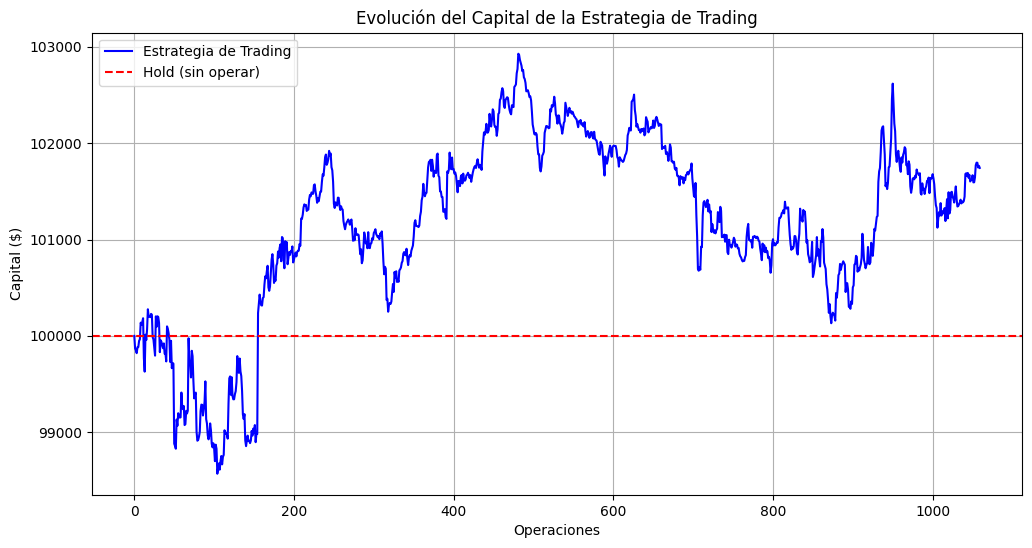

In [40]:
# Añadir las predicciones al conjunto de datos etiquetado
labeled_data['predictions'] = predictions

# Inicializar el capital y una lista para almacenar los retornos
capital = 100000  # por ejemplo
returns = []

# Iterar a través del DataFrame y simular operaciones
for i, row in labeled_data.iterrows():
    # Si el modelo predice una bajada y tienes capital para vender
    if row['predictions'] == 1 and capital >= row['close']:
        # Vender: mantener el capital, calcular retorno cuando compras en el próximo periodo
        try:
            # Calcular retorno cuando se sale de la operación en la siguiente vela
            returns.append((row['close'] - labeled_data.loc[i+1, 'close']) / labeled_data.loc[i+1, 'close'])
        except KeyError:  # Si es la última fila del DataFrame
            pass
    
# Calcular métricas de rendimiento, como la rentabilidad total y la rentabilidad promedio por operación
total_return = sum(returns)
average_return = sum(returns) / len(returns) if returns else 0

(total_return, average_return)

import matplotlib.pyplot as plt

# Calculando los retornos acumulativos
cumulative_returns = [capital]
for ret in returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret))

# Graficando
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Estrategia de Trading", color='blue')
plt.axhline(y=capital, color='r', linestyle='--', label="Hold (sin operar)")
plt.xlabel("Operaciones")
plt.ylabel("Capital ($)")
plt.title("Evolución del Capital de la Estrategia de Trading")
plt.legend()
plt.grid(True)
plt.show()